# Fit One profile in One Band

- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : April 25th 2020
- update date :


Study the relative atmosphere relative to an ideal profile in **libradtran/info_verbose/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT**
- no aerosol
- pwv =4 mm
- ozone = 3000 DU
- No extinction coefficient
- airmass = 1


Last verification : December 14th 2021  --> NOT OK Need to correct for new version of minuit


see https://iminuit.readthedocs.io/en/stable/tutorial/basic_tutorial.html


In [273]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
import os
import sys
import re
%matplotlib inline

In [274]:
from astropy.io import fits

In [275]:
from pprint import pprint # we use this to pretty print some stuff later

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

from iminuit import minimize  # has same interface as scipy.optimize.minimize

In [276]:
from datetime import datetime,date
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [277]:
#to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [278]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [279]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configuration

## Filter boudaries

In [280]:
file_wavelengthbins="data/WaveLengthBins.csv"

In [281]:
df=pd.read_csv(file_wavelengthbins,index_col=0)

In [282]:
df

,band,wl_aver,wl_wdth,wl_min,wl_max
0,u,356.0,78.0,317.0,395.0
1,g,472.0,154.0,395.0,549.0
2,r,619.0,140.0,549.0,689.0
3,i,754.0,130.0,689.0,819.0
4,z,870.5,103.0,819.0,922.0
5,y,1010.0,176.0,922.0,1098.0


In [283]:
NBFILTER=len(df)

In [284]:
FILTER_NAME=df["band"].values
WL_MIN=df["wl_min"].values
WL_MAX=df["wl_max"].values

## Absorption pattern

In [285]:
file_abspattern="data/absorption_pattern.csv"

In [286]:
df_atm=pd.read_csv(file_abspattern,index_col=0)

In [287]:
print(df_atm.columns.tolist())

['wl', 'o2_10', 'o2_11', 'o2_12', 'o2_13', 'o2_14', 'o2_15', 'o2_16', 'o2_17', 'o2_18', 'o2_19', 'o2_20', 'o2_21', 'o2_22', 'o2_23', 'o2_24', 'o2_25', 'o3_10', 'o3_11', 'o3_12', 'o3_13', 'o3_14', 'o3_15', 'o3_16', 'o3_17', 'o3_18', 'o3_19', 'o3_20', 'o3_21', 'o3_22', 'o3_23', 'o3_24', 'o3_25', 'h2o_10', 'h2o_11', 'h2o_12', 'h2o_13', 'h2o_14', 'h2o_15', 'h2o_16', 'h2o_17', 'h2o_18', 'h2o_19', 'h2o_20', 'h2o_21', 'h2o_22', 'h2o_23', 'h2o_24', 'h2o_25', 'no2_10', 'no2_11', 'no2_12', 'no2_13', 'no2_14', 'no2_15', 'no2_16', 'no2_17', 'no2_18', 'no2_19', 'no2_20', 'no2_21', 'no2_22', 'no2_23', 'no2_24', 'no2_25']


In [288]:
rootfilename=file_abspattern.split(".")[0]

In [289]:
all_df_atm=[]
for iband in np.arange(NBFILTER):
    filename=rootfilename+"_"+FILTER_NAME[iband]+".csv"
    print("====================",filename,"=======================")
    df=pd.read_csv(filename,index_col=0)
    #df=df.reset_index(drop=True)
    all_df_atm.append(df)

==================== data/absorption_pattern_u.csv =======================
==================== data/absorption_pattern_g.csv =======================
==================== data/absorption_pattern_r.csv =======================
==================== data/absorption_pattern_i.csv =======================
==================== data/absorption_pattern_z.csv =======================
==================== data/absorption_pattern_y.csv =======================


## Atmospheric data

In [290]:
DATADIR="../data/atm"

## Reference atmosphere

In [291]:
data=np.loadtxt("data/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT")
wl0=data[:,0]
transm0=data[:,1]

## Decoding function

In [292]:
def GetAtmosphericProfiles(dir,wl_ref,transm_ref):
    """
    """
    atmospheric_basename_files=os.listdir(dir)
    inputfile=os.path.join(DATADIR,atmospheric_basename_files[0])
    
    idx=0
    # containers
    all_data=[]
    all_hdr=[]
    all_wl=[]
    
    # loop on files
    for file in atmospheric_basename_files:
        if re.search("^lsst_atm_10year_[0-9][0-9].*fits$",file):
            inputfile=os.path.join(DATADIR,file)
            hdu = fits.open(inputfile)
            all_hdr.append(hdu[0].header)
            all_data.append(hdu[0].data[1:,:])
            all_wl.append(hdu[0].data[0,:])
            idx+=1
            hdu.close()
        
    data=np.vstack(all_data)
    hdr=all_hdr[0]
    
    #decode index from header
    NbAtmSimul=hdr['NBATMSIM']
    idx_out_num=hdr['ID_NUM']
    idx_out_year=hdr['ID_YEAR']
    idx_out_am=hdr['ID_AM']
    idx_out_vaod=hdr['ID_VAOD']
    idx_out_pwv=hdr['ID_PWV']
    idx_out_o3=hdr['ID_O3']
    idx_out_cld=hdr['ID_CLD']
    idx_out_res=hdr['ID_RES']
    
    vaod=data[:,idx_out_vaod] # vertical aerosol depth
    pwv=data[:,idx_out_pwv]   # precipitable water vapor (mm)
    o3=data[:,idx_out_o3]     # ozone
    cld=data[:,idx_out_cld]   # clouds (not used)
    
    
    # Extract wavelength Wavelength
    wl=all_wl[0][idx_out_res:]
    transm=data[:,idx_out_res:]
    
    if len(wl)==len(wl_ref) and wl[0]== wl_ref[0]:
        transm/=transm_ref
    else:
        print("error reference does not match")
        
    
    return wl,transm,vaod,pwv,o3,cld
     

# Open all atmospheric files

In [293]:
wl,transm,vaod,pwv,o3,cld=GetAtmosphericProfiles(DATADIR,wl0,transm0)

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_39002/739383027.py:49: RuntimeWarning: divide by zero encountered in true_divide
  transm/=transm_ref
/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_39002/739383027.py:49: RuntimeWarning: invalid value encountered in true_divide
  transm/=transm_ref


In [294]:
NBSIM=transm.shape[0]

# Distribute the relative transmission in the different filters

In [295]:
all_wl_filt=[]
all_transm_filt=[]
for iband in np.arange(NBFILTER):
    wl_indexes=np.where(np.logical_and(wl>=WL_MIN[iband],wl<=WL_MAX[iband]))[0]
    wl_filt=wl[wl_indexes]
    transm_filt=transm[:,wl_indexes]
    all_wl_filt.append(wl_filt)
    all_transm_filt.append(transm_filt)

In [296]:
all_transm_filt[0].shape

(3650, 79)

# Preview

In [297]:
IDX_SIM=1

In [298]:
# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSIM)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSIM), alpha=1)

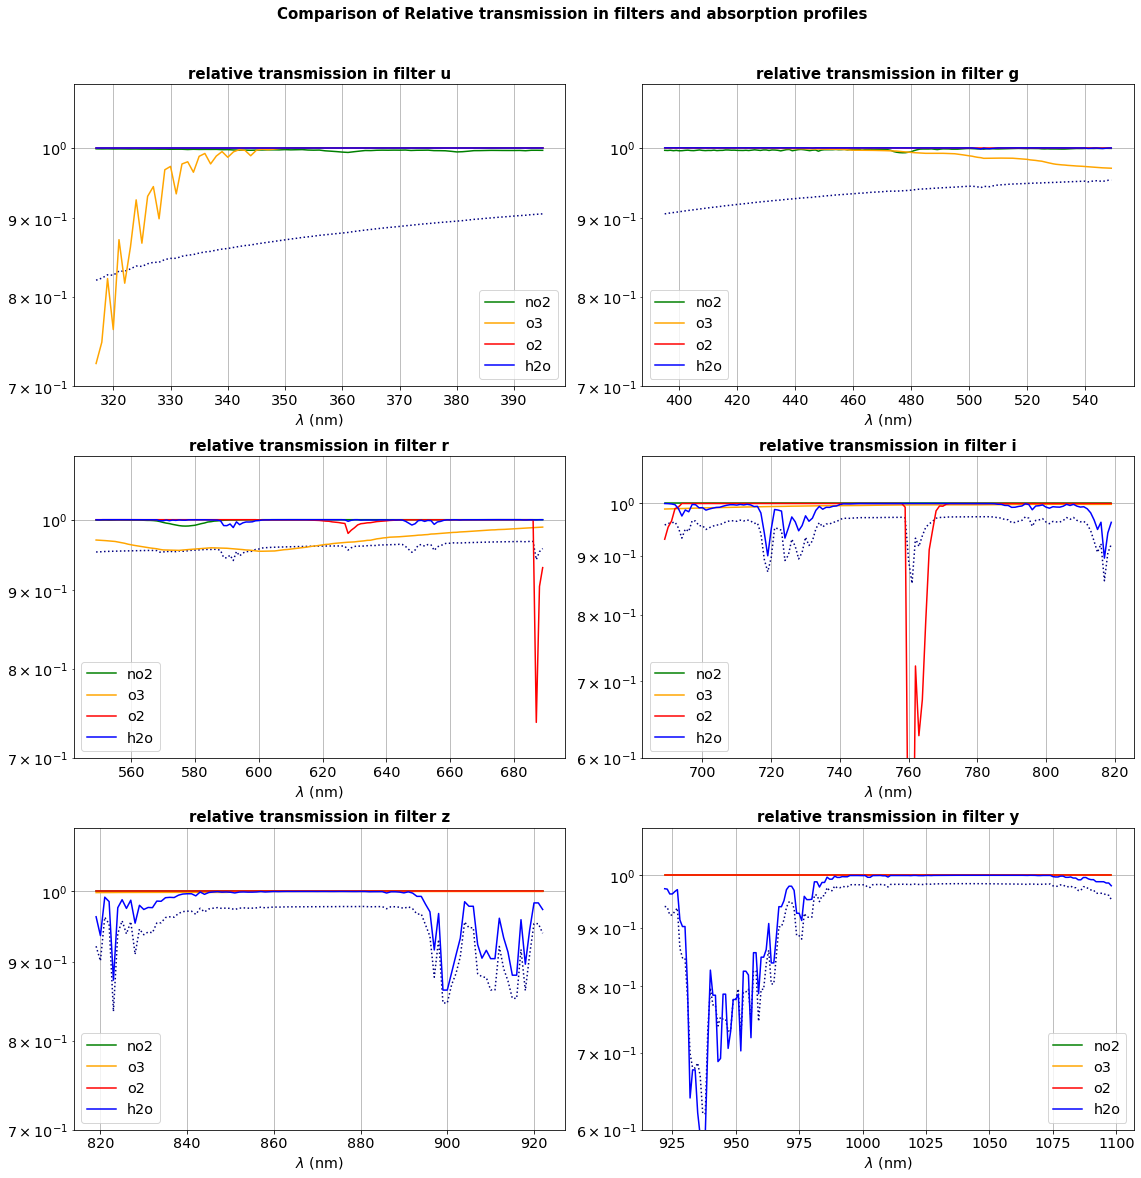

In [299]:
plt.figure(figsize=(16,16))
# loop on filter
for iband in np.arange(NBFILTER):
   
    wl=all_wl_filt[iband]
    transm=all_transm_filt[iband] 
    
    plt.subplot(3,2,iband+1)  
    # loop on simulation
    for idx in np.arange(IDX_SIM,IDX_SIM+1):
        
        colorVal=scalarMap.to_rgba(idx, alpha=1)
        plt.plot(wl,transm[idx,:],":",color=colorVal)
        
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["no2_12"],"g-",label="no2")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["o3_12"],"-",color="orange",label="o3")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["o2_12"],"r-",label="o2")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["h2o_12"],"b-",label="h2o")
            
    plt.grid(True)
    if iband<=2:
        plt.ylim(0.7,1.1)
    elif iband<=3:
        plt.ylim(0.6,1.1)
    elif iband<=4:
        plt.ylim(0.7,1.1)
    else:
        plt.ylim(0.6,1.1)
        
    plt.yscale("log")
    plt.xlabel("$\lambda$ (nm)")
    plt.legend(loc="best")
    title="relative transmission in filter {}".format(FILTER_NAME[iband])
    plt.title(title,fontweight="bold",fontsize=15)
plt.suptitle("Comparison of Relative transmission in filters and absorption profiles",fontweight="bold",fontsize=15,y=1.02)
figname=string_date+"_RelativeTransmissionFiltersAndAbsPatterns.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()  

# Fit

In [300]:
def Chi2OneFiltAbsPatternAndGrey_np(params):
    """
    Chi2(data,patterns,params) compute the chi2 in one band
    
    The format is complient with iMinuit
    
    External DATA_,PATTERNS_
    
    
    - data: one numpy array of data (ratio for each wavelength bin)
    - patterns : list of arrays of absorption patterns
    - params : array of values one grey plus one factor for each of the pattern 
    
    The data and the patterns much match in size
    
    Compute the chi2: 
    
    Note no error is probided at the moment
    
    """
    
    global DATA_
    global PATTERNS_
    
    NBPATTERNS=len(PATTERNS_)
    assert len(params)== NBPATTERNS+1
   
    # compute the difference between the data and the model
    diff=DATA_-params[0]
    
    # loop on the components of the patterns
    for idx_component in np.arange(NBPATTERNS):
        diff-=params[idx_component+1]*PATTERNS_[idx_component]
        
    diff2=diff**2    # compute the difference 
    chi2=diff2.sum() # compute the sum
    
    return chi2
    

## Fit in Y filter : H2O and Grey scale

In [301]:
iband=5

In [302]:
DATA_=transm[IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values] # only one pattern
PARAMS0_   = np.array([0,1])
PARAMSERR_ = np.array([0.0001,0.0001])

In [303]:
#m = Minuit.from_array_func(Chi2OneFiltAbsPatternAndGrey_np, PARAMS0_, error=PARAMSERR_, name = ("grey", "h2o"),errordef=1)
#m.get_param_states()

m = Minuit(Chi2OneFiltAbsPatternAndGrey_np, PARAMS0_,name = ("grey", "h2o")) 
m.errors  = PARAMSERR_
m.errordef= Minuit.LEAST_SQUARES

In [304]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,grey,0,0.1e-3,,,,,
1,h2o,1.0000,0.0001,,,,,


In [305]:
migrad_res=m.migrad()
migrad_res

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.04361                    │              Nfcn = 35               │
│ EDM = 7.2e-23 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ grey │    0.1    │    0.7    │            │            │         │         │       │
│ 1 │ h2o  │    0.9    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────┐
│      │   grey    h2o │
├──────┼───────────────┤
│ grey │  0.501 -0.525 │
│  h2o │ -0.525  0.557 │
└──────┴───────────────┘

In [306]:
for p in m.params:
    print(repr(p))

Param(number=0, name='grey', value=0.0796277530454525, error=0.7079184285219947, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None)
Param(number=1, name='h2o', value=0.8962633183743826, error=0.7461921450707526, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None)


In [307]:
grey_fit=m.values[0]
h2o_fit=m.values[1]
grey_fit_err=m.errors[0]
h2o_fit_err=m.errors[1]

In [308]:
wl=all_wl_filt[iband]
transm=all_transm_filt[iband][IDX_SIM,:]

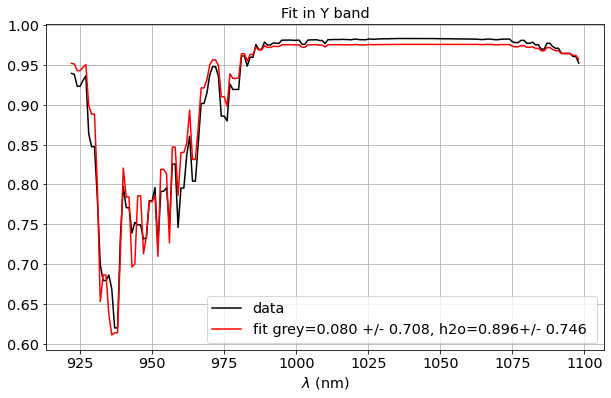

In [309]:
plt.title("Fit in Y band")
plt.plot(wl,DATA_,"k-",label="data")
label="fit grey={:1.3f} +/- {:1.3f}, h2o={:1.3f}+/- {:1.3f} ".format(grey_fit,grey_fit_err,h2o_fit,h2o_fit_err)
plt.plot(wl,grey_fit+h2o_fit*PATTERNS_[0],'r-',label=label)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

In [310]:
type(m.values)

iminuit.util.ValueView

In [311]:
pprint(m.fval)

0.0436051556133321


In [312]:
#for key, value in m.values.items():
for x in m.values:
    pprint(x)

0.0796277530454525
0.8962633183743826


In [313]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,grey,0.1,0.7,,,,,
1,h2o,0.9,0.7,,,,,


In [314]:
hesse_res=m.hesse()
hesse_res

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.04361                    │              Nfcn = 45               │
│ EDM = 7.81e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ grey │    0.1    │    0.7    │            │            │         │         │       │
│ 1 │ h2o  │    0.9    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────┐
│      │   grey    h2o │
├──────┼───────────────┤
│ grey │  0.501 -0.525 │
│  h2o │ -0.525  0.557 │
└──────┴───────────────┘

In [315]:
#m.matrix(correlation=True)
hesse_res.covariance

,grey,h2o
grey,0.501,-0.525 (-0.994)
h2o,-0.525 (-0.994),0.557


In [316]:
hesse_res.covariance.correlation()  

,grey,h2o
grey,1,-0.994
h2o,-0.994,1


In [317]:
minos_res=m.minos()
minos_res

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.04361                    │              Nfcn = 69               │
│ EDM = 7.81e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ grey │    0.1    │    0.7    │    -0.7    │    0.7     │         │         │       │
│ 1 │ h2o  │    0.9    │    0.7    │    -0.7    │    0.7     │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │         grey          │          h2o          │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.7    │    0.7    │   -0.7    │    0.7    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌──────┬───────────────┐
│      │   grey    h2o │
├──────┼───────────────┤
│ grey │  0.501 -0.525 │
│  h2o │ -0.525  0.557 │
└──────┴───────────────┘

In [318]:
# iterate over values
for key, value in zip(m.parameters, m.values):
    print(f"{key} = {value}")

grey = 0.0796277530454525
h2o = 0.8962633183743826


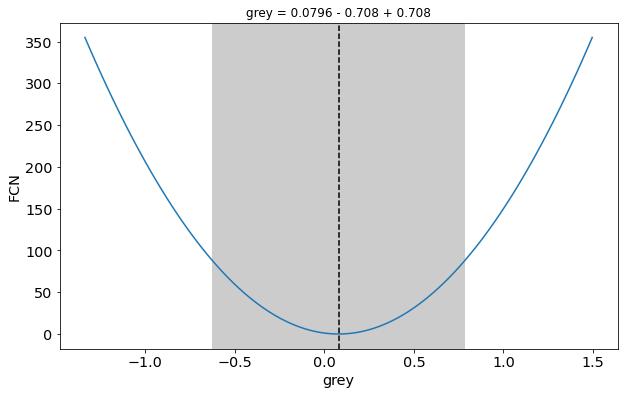

In [319]:
m.draw_profile("grey");

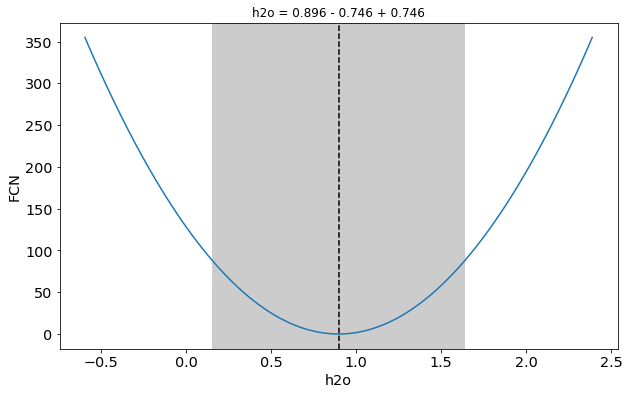

In [320]:
m.draw_profile("h2o");

E MnContours unable to find point on Contour 69 
 found only 68 points
E MnContours unable to find point on Contour 69 
 found only 68 points
E MnContours unable to find point on Contour 69 
 found only 68 points


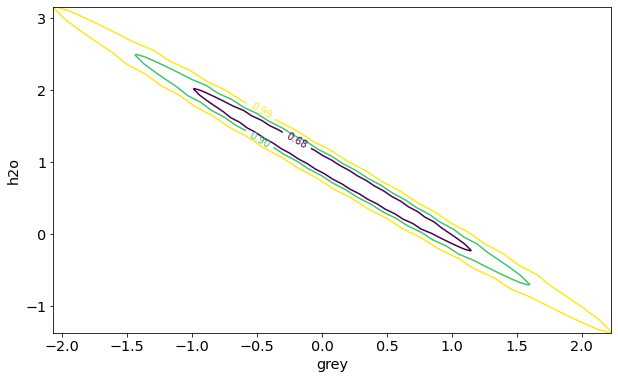

In [321]:
# draw three contours with 68%, 90%, 99% confidence level
m.draw_mncontour('grey','h2o', cl=(0.68, 0.9, 0.99))

Text(0.5, 0, 'grey')

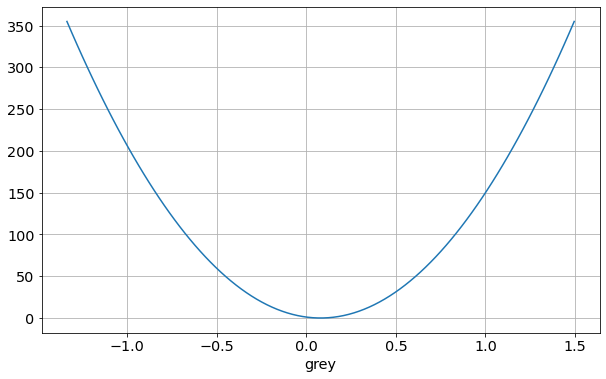

In [322]:
# 1D value Scan
a, fa = m.profile('grey')
plt.plot(a, fa);
plt.grid()
plt.xlabel("grey")

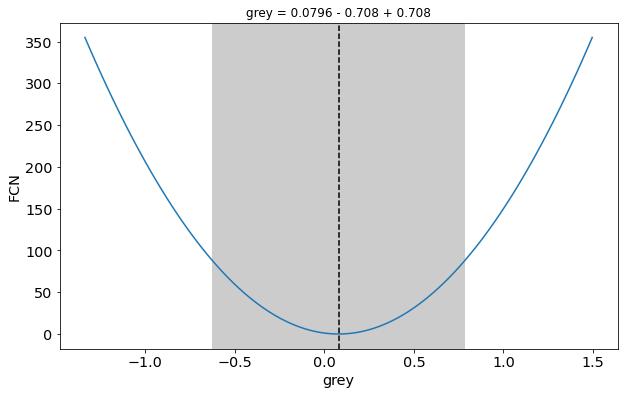

In [323]:
# or use this function for a quick look
m.draw_profile('grey');

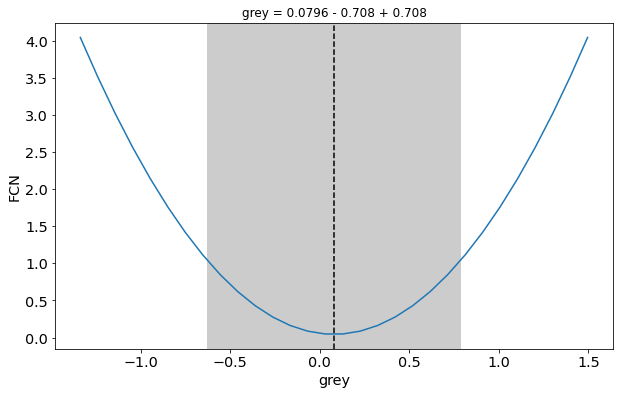

In [324]:
m.draw_mnprofile('grey');

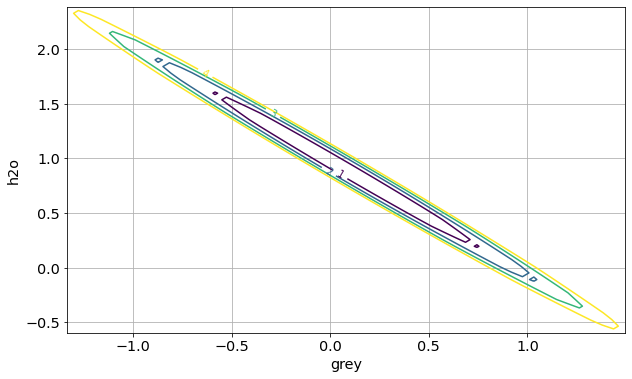

In [325]:
x,y,z = m.contour('grey', 'h2o', subtract_min=True)
cs = plt.contour(x,y,z, (1, 2, 3, 4)) # these are not sigmas, just the contour values
plt.clabel(cs);
plt.xlabel("grey")
plt.ylabel("h2o")
plt.grid()

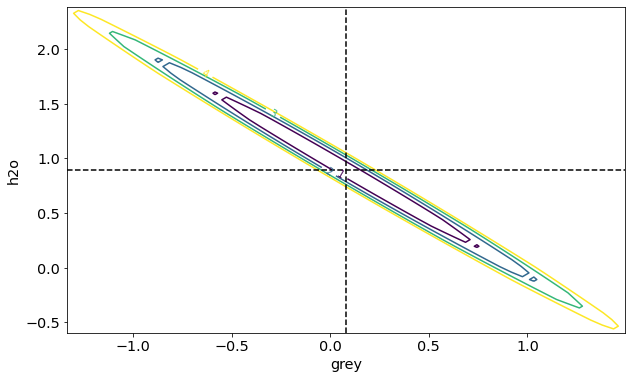

In [326]:
# or use this function for a quick look
m.draw_contour('grey', 'h2o');